In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [4]:
x = torch.tensor(np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]],dtype=np.float32))
x = x.unsqueeze(0).unsqueeze(0)

# x = torch.rand(10,1,32,32)

# cl = nn.Conv2d(
#     in_channels  = 1,
#     out_channels = 500,
#     kernel_size  = 3)

# out = cl(x)
#print(out.size())

mp = nn.MaxPool2d(2,stride=1)
print(mp(x))
# # x = torch.randn(10,1,5,5)
# # cl(x).size()


tensor([[[[5., 6.],
          [8., 9.]]]])


# Conv.-Net for MNIST
Next, we implement a simple convolutional neural network to classify MNIST images. First, lets specify the **network architecture**.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Define layers (2 conv layers, 2 fully-connected layers)
        self.conv1 = nn.Conv2d(1,  10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    # Specify the data flow through the model
    def forward(self, x):
        
        # Conv->Pool->ReLU
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Conv->Pool->ReLU
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Reshape output into (batch-size x 320)
        x = x.view(-1, 320)
        # fully-connected->ReLU
        x = F.relu(self.fc1(x))
        # fully-connected
        x = self.fc2(x)
        return x

Lets write our **training routine** for one epoch!

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    # set model to training mode
    model.train()
    train_loss = 0
    
    # iterate over all batches of (img,label) from train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # device-agnostic code - if CUDA is available -> use it
        data, target = data.to(device), target.to(device)
        
        # reset gradients
        optimizer.zero_grad()
        
        # forward pass 
        output = model(data)
        
        # compute loss
        loss = F.cross_entropy(output, target, reduction='sum')
        train_loss += loss.item() 
        
        loss = loss/data.size(0)
        
        # compute gradients
        loss.backward()
        
        # update paramters
        optimizer.step()

        # some logging
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    return train_loss

Lets write our **testing routine** which we will call after one epoch of training!

In [7]:
def test(model, device, test_loader):

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    
    # temporarily set all the requires_grad flag to False
    with torch.no_grad():
        
        # iterate over testing batches  (img, label)
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            
            # forward pass 
            output = model(data)
            
            # track cross-entropy-loss on testing data
            test_loss += F.cross_entropy(output, target, reduction='sum').item() 
            
            # get the correct class prediction as the max. value of the last fully-connected layer
            # Remember, the cross-entropy-loss operates on top of that layer! In that sense, the 
            # output of the last layer can be interpreted as the log-prob. of each class.
            pred = output.max(1, keepdim=True)[1] 
            
            # Track how many labels were correctly predicted
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Overall testing loss
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss

In [8]:
# some named args that are passed to the dataloader
kwargs = {
    'num_workers': 1, 
    'pin_memory': True} if use_cuda else {}

"""From the docs:

Host to GPU copies are much faster when they originate 
from pinned (page-locked) memory. CPU tensors and storages 
expose a pin_memory() method, that returns a copy of the object, 
with data put in a pinned region.

Also, once you pin a tensor or storage, you can use 
asynchronous GPU copies. Just pass an additional non_blocking=True 
argument to a cuda() call. This can be used to overlap data 
transfers with computation.

You can make the DataLoader return batches placed in pinned memory 
by passing pin_memory=True to its constructor.
"""

# Create a training loader for MNIST - this loader will supply mini-batches of size 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=64, shuffle=True, **kwargs)

# Create a testing loader for MNIST - this loader will supply mini-batches of size 64
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=False, **kwargs)

In [18]:
# initialize the model and put it onto the GPU (if device='cuda')
model = Net().to(device)

# create a SGD optimizer
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.001, 
    momentum=0.9) # we'll discuss momentum later on

# Now, iterate over a couple of epochs ...

train_losses = []
test_losses  = []

for epoch in range(1, 2):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss  = test(model, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309327
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.177939
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.436310
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.586512
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.374674
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.315199
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.309613
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.368463
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.303184
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.268100

Test set: Average loss: 0.1996, Accuracy: 9441/10000 (94%)



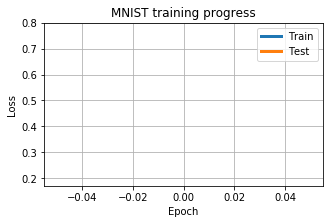

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(train_losses, lw=3)
plt.plot(test_losses, lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MNIST training progress')
plt.legend(['Train','Test'])
plt.grid()

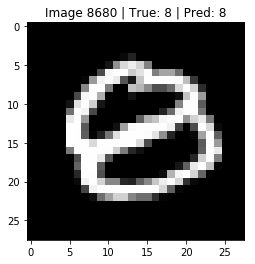

In [20]:
idx = np.random.randint(0,len(test_loader.dataset))

model = model.to('cuda')
img, label = train_loader.dataset[idx]
plt.imshow(img.permute(1,2,0).numpy()[:,:,0],cmap='gray')

img = img.to('cuda')
pred = model(img.unsqueeze(0)).max(1,keepdim=True)[1].item()

plt.title('Image {} | True: {} | Pred: {}'.format(
    idx, label, pred));

In [21]:
s = 0
for p in model.parameters(): s+=p.numel()
print(s)

21840
